In [1]:
import pandas as pd
import numpy as np
from matplotlib.animation import FuncAnimation
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

sns.set_theme(style="whitegrid")

In [33]:
# EIP4844 configuration
# MAX_BLOB_GAS_PER_BLOCK = 786432
# TARGET_BLOB_GAS_PER_BLOCK = 393216
MIN_BASE_FEE_PER_BLOB_GAS = 1
BLOB_BASE_FEE_UPDATE_FRACTION = 3338477
GAS_PER_BLOB = 2**17

MAX_BLOBS_PER_BLOCK_ELECTRA = 9
TARGET_BLOBS_PER_BLOCK_ELECTRA = 6
MAX_BLOB_GAS_PER_BLOCK = 1179648
TARGET_BLOB_GAS_PER_BLOCK = 786432
BLOB_BASE_FEE_UPDATE_FRACTION_PRAGUE = 5007716

# simuplation configuration
TIMESTEMPS = 5 * 60 * 24 * 2
RUNS = 200

In [3]:
# EIP-4844 Pricing Formula

def fake_exponential(factor: int, numerator: int, denominator: int) -> int:
    i = 1
    output = 0
    numerator_accum = factor * denominator
    while numerator_accum > 0:
        output += numerator_accum
        numerator_accum = (numerator_accum * numerator) // (denominator * i)
        i += 1
    return output // denominator

def fake_exponential_bn(factor: int, numerator: int, denominator: int) -> int:
    _factor = np.int64(factor)
    _numerator = np.int64(numerator)
    _denominator = np.int64(denominator)
    i = np.int64(1)
    _output = np.int64(0)
    _numerator_accum = _factor * _denominator
    while _numerator_accum > 0:
        _output = np.add(_output, _numerator_accum, dtype=object)
        _numerator_accum = np.floor_divide(np.multiply(_numerator_accum, _numerator, dtype=object), np.multiply(_denominator, i, dtype=object), dtype=object)
        i += 1
    return np.floor_divide(_output, _denominator, dtype=object)

def calc_excess_blob_gas(target_blob_gas_per_block: int, parent_excess_blob_gas: int, parent_blob_gas_used: int) -> int:
    if parent_excess_blob_gas + parent_blob_gas_used < target_blob_gas_per_block:
        return 0
    else:
        return parent_excess_blob_gas + parent_blob_gas_used - target_blob_gas_per_block

def get_base_fee_per_blob_gas(min_base_fee_per_blob_gas: int, excess_blob_gas: int, blob_base_fee_update_fraction: int) -> int:
    return fake_exponential(
        min_base_fee_per_blob_gas,
        excess_blob_gas,
        blob_base_fee_update_fraction
    )

In [4]:
# EIP-4844 Blob Fee Market Model

def policy_resource_fee(params, substep, state_history, previous_state):
    target_blob_gas_per_block = params['target_blob_gas_per_block']

    parent_blob_gas_used = previous_state['blob_gas_used']
    parent_excess_blob_gas = previous_state['excess_blob_gas']

    excess_blob_gas = calc_excess_blob_gas(target_blob_gas_per_block, parent_excess_blob_gas, parent_blob_gas_used)

    return {
        'excess_blob_gas': excess_blob_gas
    }

def policy_resource_usage(params, substep, state_history, previous_state):
    process_blob_gas_used = params['process_blob_gas_used']
    
    run = previous_state['run']
    timestep = previous_state['timestep']

    blob_gas_used = process_blob_gas_used(run, timestep)

    return {
        'blob_gas_used': blob_gas_used
    }

def update_excess_blob_gas(params, substep, state_history, previous_state, policy_input):
    excess_blob_gas = policy_input['excess_blob_gas']
    return ('excess_blob_gas', excess_blob_gas)

def update_blob_gas_used(params, substep, state_history, previous_state, policy_input):
    blob_gas_used = policy_input['blob_gas_used']
    return ('blob_gas_used', blob_gas_used)

initial_state = {
    'blob_gas_used': 0,
    'excess_blob_gas': 0,
}

state_update_blocks = [
    {
        'policies': {
            'resource_fee': policy_resource_fee,
        },
        'variables': {
            'excess_blob_gas': update_excess_blob_gas,
        }
    },
    {
        'policies': {
            'resource_usage': policy_resource_usage,
        },
        'variables': {
            'blob_gas_used': update_blob_gas_used,
        }
    },
]

In [34]:
# Demand Sampling

rng = np.random.default_rng()

def truncated_poisson(lam: int, max_value: int, size: int):
    temp_size = size
    while True:
        temp_size *= 2
        temp = rng.poisson(lam=lam, size=temp_size)
        truncated = temp[temp <= max_value]
        if len(truncated) >= size:
            return truncated[:size]
    
def generate_poisson_demand(lam: int):
    return [truncated_poisson(lam=lam, max_value=MAX_BLOBS_PER_BLOCK_ELECTRA, size=TIMESTEMPS + 1) * GAS_PER_BLOB for run in range(RUNS)]

def generate_uniform_demand():
    return rng.integers(low=0, high=MAX_BLOBS_PER_BLOCK_ELECTRA, size=(RUNS, TIMESTEMPS + 1), endpoint=True) * GAS_PER_BLOB

def generate_bimodal_demand():
    a = range(MAX_BLOBS_PER_BLOCK_ELECTRA + 1)
    p = np.zeros(MAX_BLOBS_PER_BLOCK_ELECTRA + 1)
    p[0] = 0.5
    p[MAX_BLOBS_PER_BLOCK_ELECTRA] = 0.5
    return rng.choice(a=a, p=p, size=(RUNS, TIMESTEMPS + 1)) * GAS_PER_BLOB

In [35]:
cases = [
    {
        'name': 'The blob demand follows a Poisson distribution with lambda = 1',
        'samples': generate_poisson_demand(1)
    },
    {
        'name': 'The blob demand follows a Poisson distribution with lambda = 8',
        'samples': generate_poisson_demand(8)
    },
    {
        'name': 'The blob demand follows a Poisson distribution with lambda = 6',
        'samples': generate_poisson_demand(6)
    },
    {
        'name': 'The blob demand follows an uniform distribution',
        'samples': generate_uniform_demand()
    },
    {
        'name': 'The blob demand follows a bimodal distribution',
        'samples': generate_bimodal_demand()
    },
]

In [36]:
def create_simulation(case):
    model = Model(
        initial_state=initial_state,
        state_update_blocks=state_update_blocks,
        params={
            'target_blob_gas_per_block': [TARGET_BLOB_GAS_PER_BLOCK],
            'process_blob_gas_used': [lambda run, timestep: case['samples'][run - 1][timestep]],
        },
    )
    simulation = Simulation(
        model=model,
        timesteps=TIMESTEMPS,
        runs=RUNS
    )
    return simulation

simulations = list(map(create_simulation, cases))
experiment = Experiment(simulations=simulations)
experiment.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)
result = experiment.run()

python(3563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3564) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3565) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3568) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [37]:
df = pd.DataFrame(result)
df

,blob_gas_used,excess_blob_gas,simulation,subset,run,substep,timestep
0,0,0,0,0,1,0,0
1,131072,0,0,0,1,2,1
2,0,0,0,0,1,2,2
3,262144,0,0,0,1,2,3
4,131072,0,0,0,1,2,4
...,...,...,...,...,...,...,...
14400995,1179648,1966080,4,0,200,2,14396
14400996,0,2359296,4,0,200,2,14397
14400997,0,1572864,4,0,200,2,14398
14400998,0,786432,4,0,200,2,14399


In [38]:
df_excess_blob_gas_stats = df.groupby(['simulation', 'timestep'])['excess_blob_gas'].describe()
df_excess_blob_gas_stats["base_fee_per_blob_gas"] = df_excess_blob_gas_stats["mean"].apply(lambda value: get_base_fee_per_blob_gas(MIN_BASE_FEE_PER_BLOB_GAS, value, BLOB_BASE_FEE_UPDATE_FRACTION_PRAGUE))
df_excess_blob_gas_stats


count       mean            std  min  25%       50%  \
simulation timestep                                                        
0          0         200.0       0.00       0.000000  0.0  0.0       0.0   
           1         200.0       0.00       0.000000  0.0  0.0       0.0   
           2         200.0       0.00       0.000000  0.0  0.0       0.0   
           3         200.0       0.00       0.000000  0.0  0.0       0.0   
           4         200.0       0.00       0.000000  0.0  0.0       0.0   
...                    ...        ...            ...  ...  ...       ...   
4          14396     200.0  727449.60  921751.889393  0.0  0.0  393216.0   
           14397     200.0  688128.00  958934.125135  0.0  0.0  393216.0   
           14398     200.0  692060.16  977781.739531  0.0  0.0  393216.0   
           14399     200.0  727449.60  989244.692167  0.0  0.0  393216.0   
           14400     200.0  674365.44  918058.747669  0.0  0.0  393216.0   

                           75%        max  base_fee_per_blob_gas  
simulation timestep                                               
0          0               0.0        0.0                    1.0  
           1               0.0        0.0                    1.0  
           2               0.0        0.0                    1.0  
           3               0.0        0.0                    1.0  
           4               0.0        0.0                    1.0  
...                        ...        ...                    ...  
4          14396     1179648.0  4718592.0                    1.0  
           14397      786432.0  5111808.0                    1.0  
           14398      786432.0  5505024.0                    1.0  
           14399      786432.0  5505024.0                    1.0  
           14400      786432.0  4718592.0                    1.0  

[72005 rows x 9 columns]

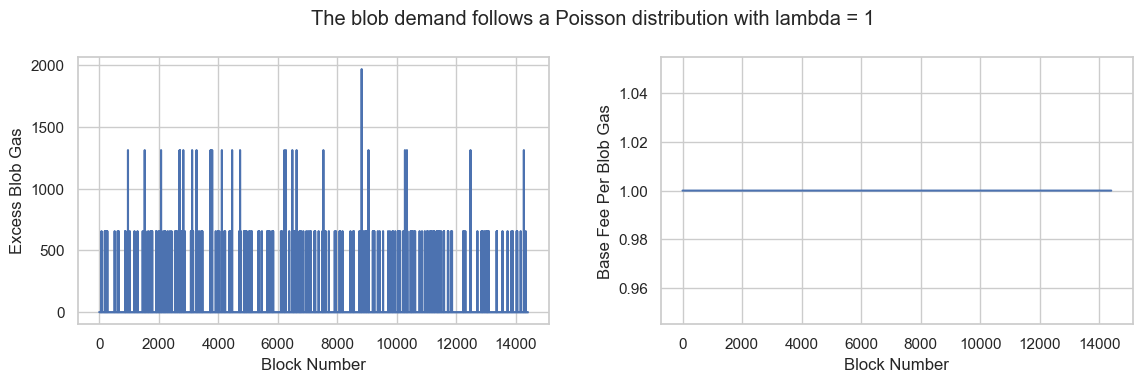

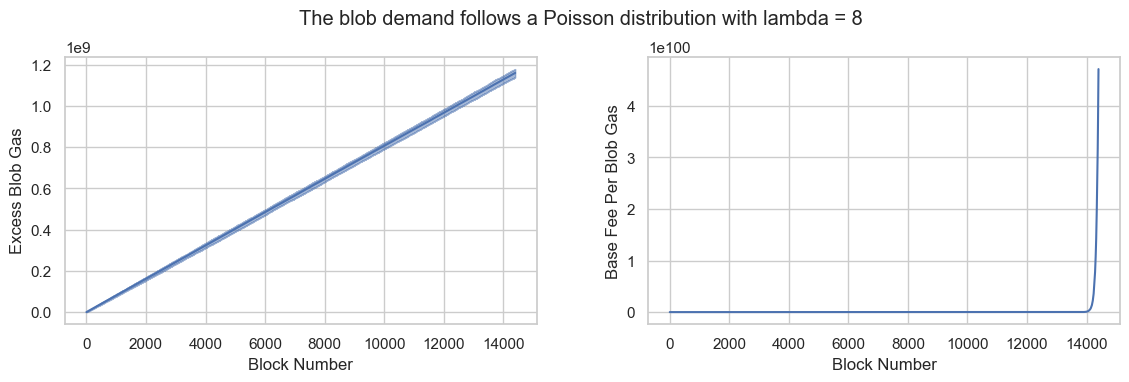

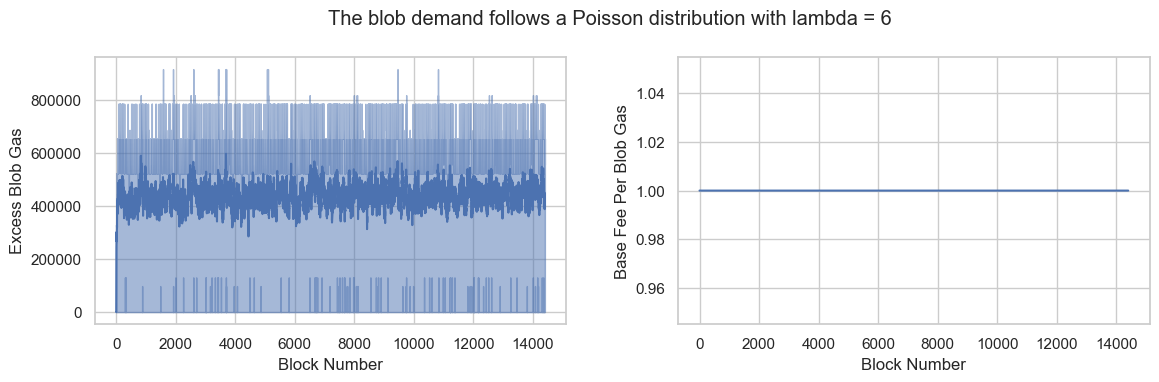

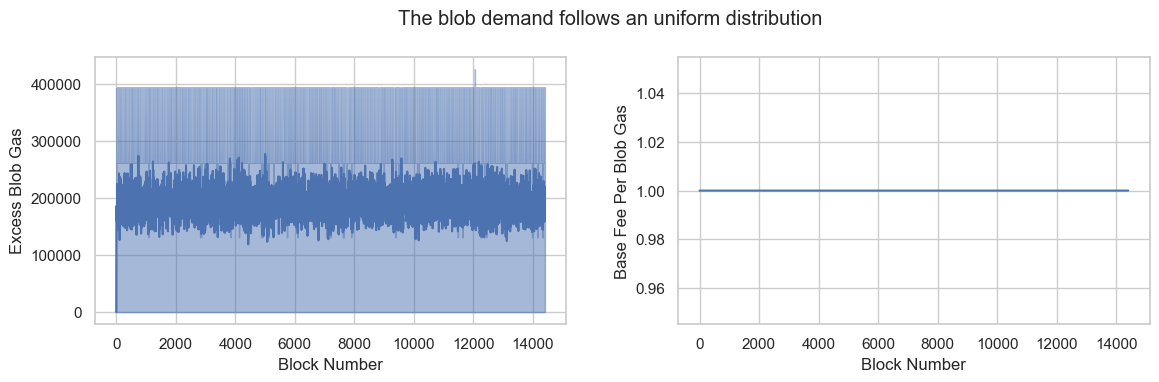

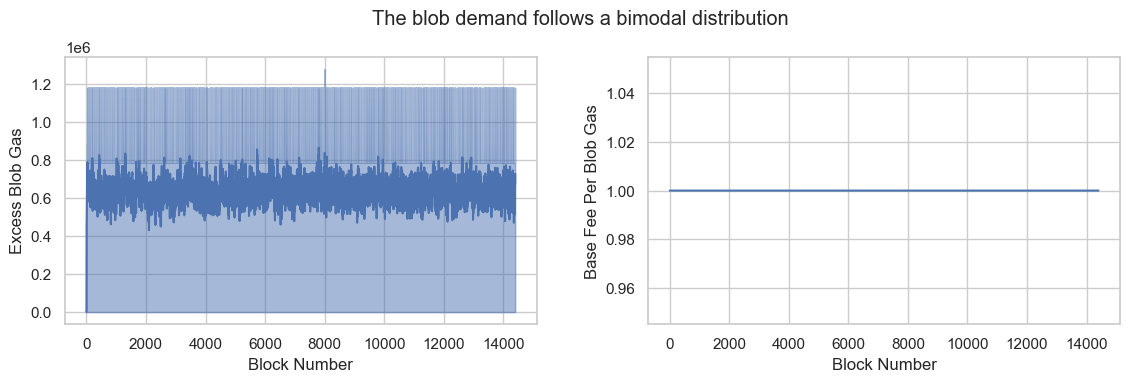

In [39]:
for index, case in enumerate(cases):
    excess_blob_gas = df_excess_blob_gas_stats.loc[index]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout(pad=3, w_pad=4, h_pad=3)
    fig.suptitle(case['name'])

    ax1.plot(excess_blob_gas.index, excess_blob_gas['mean'].values, label='Mean')
    ax1.fill_between(excess_blob_gas.index, excess_blob_gas['25%'].values, excess_blob_gas['75%'].values, color='b', alpha=0.5)
    ax1.set_xlabel('Block Number')
    ax1.set_ylabel('Excess Blob Gas')

    ax2.plot(excess_blob_gas.index, excess_blob_gas['base_fee_per_blob_gas'].values, label='Mean')
    ax2.set_xlabel('Block Number')
    ax2.set_ylabel('Base Fee Per Blob Gas')

    fig.savefig(f'img/eip7691-t{TIMESTEMPS}-r{RUNS}-c{index + 1}.png')


## Find the stable condition of the blob demand

In [27]:
demand_values = np.arange(6.55, 6.75, 0.01).round(2)

def create_simulation(demand_value: int):
    samples = generate_poisson_demand(demand_value)
    model = Model(
        initial_state=initial_state,
        state_update_blocks=state_update_blocks,
        params={
            'target_blob_gas_per_block': [TARGET_BLOB_GAS_PER_BLOCK],
            'process_blob_gas_used': [lambda run, timestep: samples[run - 1][timestep]],
        },
    )
    simulation = Simulation(
        model=model,
        timesteps=TIMESTEMPS,
        runs=RUNS
    )
    return simulation

simulations_sc = list(map(create_simulation, demand_values))
experiment_sc = Experiment(simulations=simulations_sc)
experiment_sc.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)
result_sc = experiment_sc.run()

In [28]:
df_sc = pd.DataFrame(result_sc)
df_sc

,blob_gas_used,excess_blob_gas,simulation,subset,run,substep,timestep
0,0,0,0,0,1,0,0
1,524288,0,0,0,1,2,1
2,524288,0,0,0,1,2,2
3,655360,0,0,0,1,2,3
4,655360,0,0,0,1,2,4
...,...,...,...,...,...,...,...
15121045,786432,7077888,20,0,50,2,14396
15121046,1179648,7077888,20,0,50,2,14397
15121047,655360,7471104,20,0,50,2,14398
15121048,524288,7340032,20,0,50,2,14399


In [29]:
df_stats_sc = df_sc.groupby(['simulation', 'timestep'])['excess_blob_gas'].describe()
df_stats_sc['base_fee_per_blob_gas'] = df_stats_sc['mean'].apply(lambda value: get_base_fee_per_blob_gas(MIN_BASE_FEE_PER_BLOB_GAS, value, BLOB_BASE_FEE_UPDATE_FRACTION_PRAGUE))
df_stats_sc

count         mean           std        min         25%  \
simulation timestep                                                            
0          0          50.0         0.00  0.000000e+00        0.0         0.0   
           1          50.0         0.00  0.000000e+00        0.0         0.0   
           2          50.0     94371.84  1.325086e+05        0.0         0.0   
           3          50.0    180879.36  1.979675e+05        0.0         0.0   
           4          50.0    228065.28  2.259552e+05        0.0         0.0   
...                    ...          ...           ...        ...         ...   
20         14396      50.0  35916349.44  2.145435e+07  3538944.0  18481152.0   
           14397      50.0  35916349.44  2.145882e+07  3145728.0  18317312.0   
           14398      50.0  35929456.64  2.147831e+07  2883584.0  18284544.0   
           14399      50.0  35932078.08  2.147810e+07  2752512.0  18415616.0   
           14400      50.0  35950428.16  2.148072e+07  2883584.0  18120704.0   

                            50%         75%         max  base_fee_per_blob_gas  
simulation timestep                                                             
0          0                0.0         0.0         0.0                    1.0  
           1                0.0         0.0         0.0                    1.0  
           2                0.0    131072.0    393216.0                    1.0  
           3           131072.0    393216.0    655360.0                    1.0  
           4           196608.0    393216.0    786432.0                    1.0  
...                         ...         ...         ...                    ...  
20         14396     33619968.0  53018624.0  81920000.0                 1302.0  
           14397     33357824.0  53051392.0  82313216.0                 1302.0  
           14398     33423360.0  52822016.0  82444288.0                 1306.0  
           14399     33619968.0  52756480.0  82444288.0                 1306.0  
           14400     33488896.0  52330496.0  82706432.0                 1311.0  

[302421 rows x 9 columns]

In [30]:
stable_demand_range = [None, None]

for index, demand_value in enumerate(demand_values):
    stats = df_stats_sc.loc[index]
    tail_from = TIMESTEMPS - 7200
    tail_stats = stats['mean'][tail_from:]
    trend = tail_stats.diff().mean()
    if stable_demand_range[0] is None and tail_stats.mean() > GAS_PER_BLOB * 18:
        stable_demand_range[0] = demand_value
    if trend < 1000:
        stable_demand_range[1] = demand_value

stable_demand_range

[6.56, 6.72]

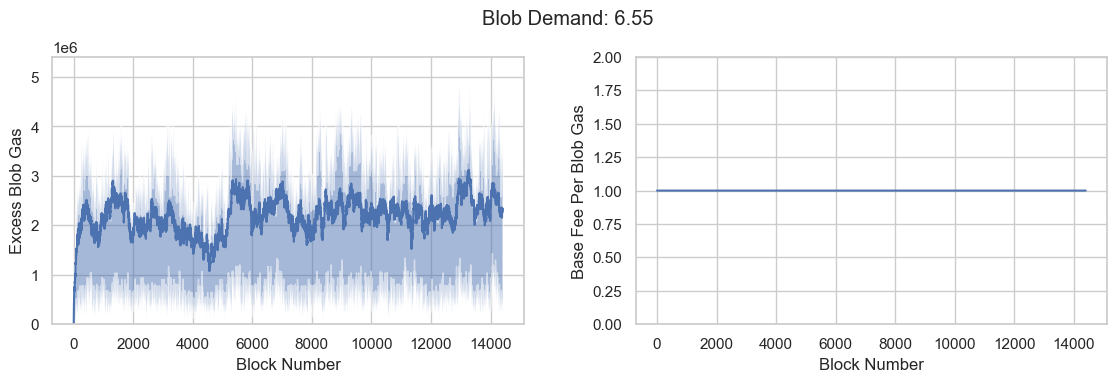

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=3, w_pad=4, h_pad=3)

ax1.set_xlabel('Block Number')
ax1.set_ylabel('Excess Blob Gas')
line1, = ax1.plot(range(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1))
area1 = ax1.fill_between(range(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1), alpha=0.5)

ax2.set_xlabel('Block Number')
ax2.set_ylabel('Base Fee Per Blob Gas')
line2, = ax2.plot(range(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1))

def updateFrame(frame: int):
    stats = df_stats_sc.loc[frame]
    fig.suptitle(f'Blob Demand: {demand_values[frame]}')
    ax1.set_ylim(top=stats['75%'].values.max() * 1.1, bottom=0)
    line1.set_ydata(stats['mean'].values)
    area1.set_data(stats.index, stats['25%'].values, stats['75%'].values)
    ax2.set_ylim(top=np.max([stats['base_fee_per_blob_gas'].max() * 1.1, 2]), bottom=0)
    line2.set_ydata(stats['base_fee_per_blob_gas'].values)

ani = FuncAnimation(fig, updateFrame, frames=range(len(demand_values)), interval=1000)
HTML(ani.to_jshtml())


In [32]:
ani.save('img/eip7691-effective-demand.gif', writer='imagemagick', fps=1)

MovieWriter imagemagick unavailable; using Pillow instead.


### Pricing Curve

Text(0.5, 1.0, 'Pricing Formula comparison')

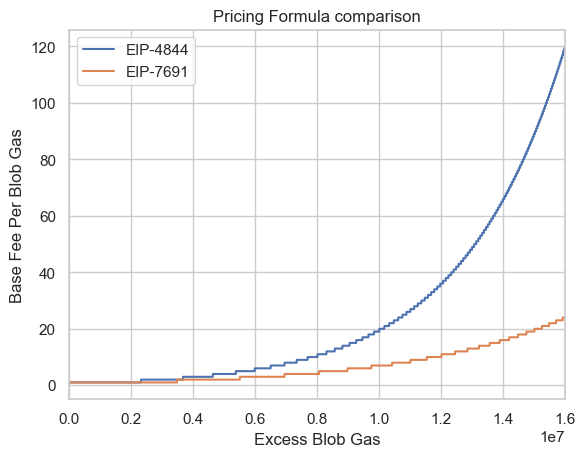

In [16]:
excess_blob_gas_values = np.arange(0, 16000000, dtype='int64')
eip4844_pricing_values = np.array([get_base_fee_per_blob_gas(MIN_BASE_FEE_PER_BLOB_GAS, gas, BLOB_BASE_FEE_UPDATE_FRACTION) for gas in excess_blob_gas_values])
eip7691_pricing_values = np.array([get_base_fee_per_blob_gas(MIN_BASE_FEE_PER_BLOB_GAS, gas, BLOB_BASE_FEE_UPDATE_FRACTION_PRAGUE) for gas in excess_blob_gas_values])

fig_pricing_formula, axs_pricing_formula = plt.subplots()
axs_pricing_formula.plot(excess_blob_gas_values, eip4844_pricing_values, label="EIP-4844")
axs_pricing_formula.plot(excess_blob_gas_values, eip7691_pricing_values, label="EIP-7691")
axs_pricing_formula.legend(loc='best')
axs_pricing_formula.set_xlim(0, 16000000)
axs_pricing_formula.set_xlabel("Excess Blob Gas")
axs_pricing_formula.set_ylabel("Base Fee Per Blob Gas")
axs_pricing_formula.set_title("Pricing Formula comparison")